In [2]:
import os
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
from scipy import linalg as la

### Helper Functions

In [3]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    Parameters:
        path (str): The directory containing the dataset of images.  
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """

    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break

    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.
    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

In [4]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    # reshape the face and show it
    face = np.reshape(image, (m, n))
    plt.imshow(face, cmap="gray")

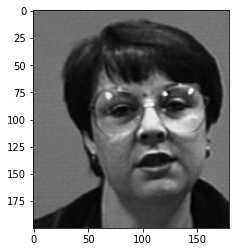

In [5]:
# get all faces and show the first one
allFaces = get_faces()
show(allFaces[:,0])

In [6]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """

    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        # get the associated face
        self.F = get_faces(path)

        # get the mean face
        self.mu = np.mean(self.F, axis=1)

        # get the mean shifted face
        self.Fbar = self.F - self.mu.reshape((len(self.mu), 1))

        # get the eigenvectors of the mean shifted face
        self.U = la.svd(self.Fbar, full_matrices=False)[0]


    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        # return an array of the projected image of s eigenfaces
        return self.U[:,:s].T @ A
        

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.
        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        # project the input shifted by the mean
        gHat = self.project(g - self.mu, s)

        # project Fbar and s and return the index of the column of F that is the best match to the input face image
        Fhat = self.project(self.Fbar, s)

        return np.argmin(la.norm(Fhat - np.vstack(gHat), axis=0))


    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        
        # find the nearest image and plot the original next to the nearest
        j = self.find_nearest(image, s)
        plt.figure(figsize=(12,10), dpi=80)
        plt.subplot(1,2,1)
        plt.title("Original Image")
        show(image)

        plt.subplot(1,2,2)
        plt.title("New Image")
        show(self.F[:,j], m, n)
        plt.show()

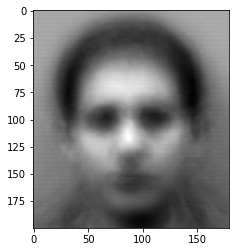

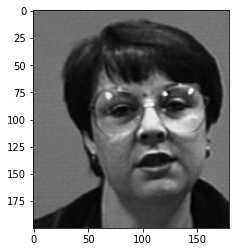

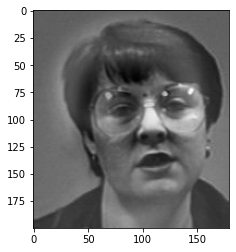

In [7]:
# get faces and display the mean face, original image, and shifted face
facialRec = FacialRec()
show(facialRec.mu)
plt.show()

show(facialRec.F[:,0])
plt.show()

show(facialRec.Fbar[:,0])
plt.show()

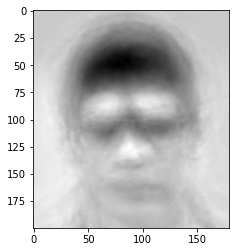

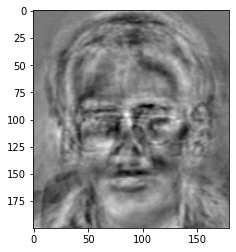

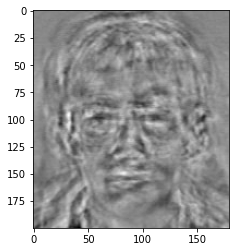

In [8]:
# display eigenfaces for 1, 50, and 100
show(facialRec.U[:,1])
plt.show()

show(facialRec.U[:,50])
plt.show()

show(facialRec.U[:,100])
plt.show()

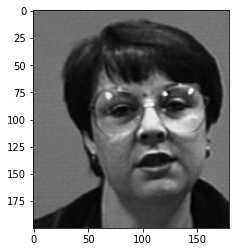

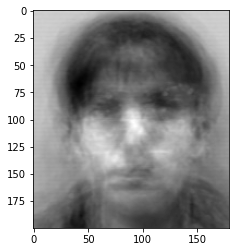

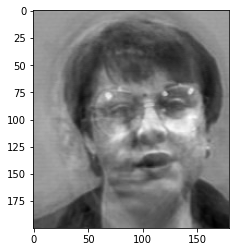

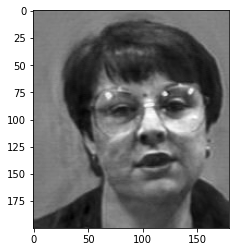

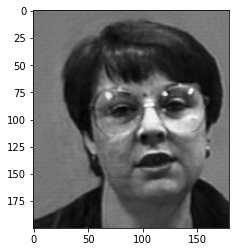

In [9]:
# compute s-projection and the reconstruction
facial = FacialRec()
fi = facial.Fbar[:,0]
show(facial.F[:,0])
plt.show()

eigFaces = [5, 19, 50, 75]
# display original image next to reconstructions
for s in eigFaces:
    show(facial.U[:,:s] @ facial.project(fi, s) + facial.mu)
    plt.show()

In [10]:
# print result of find_nearest method
print(facial.find_nearest(facial.F[:,3]))

3


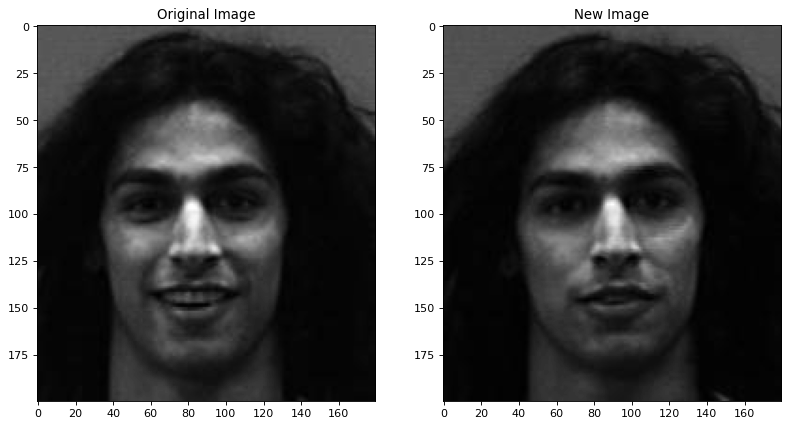

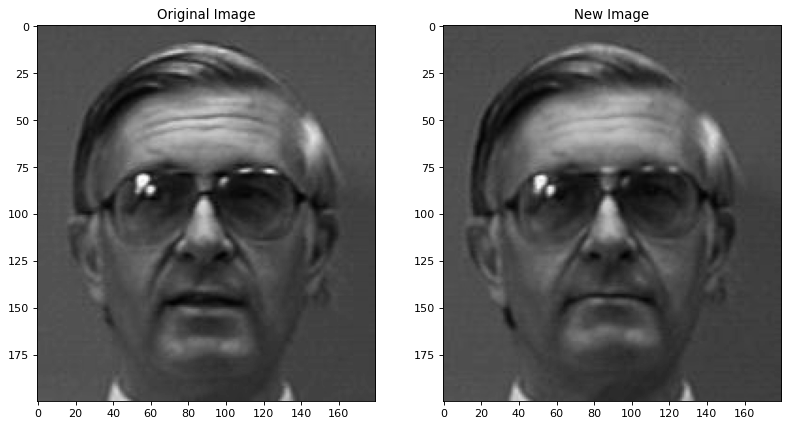

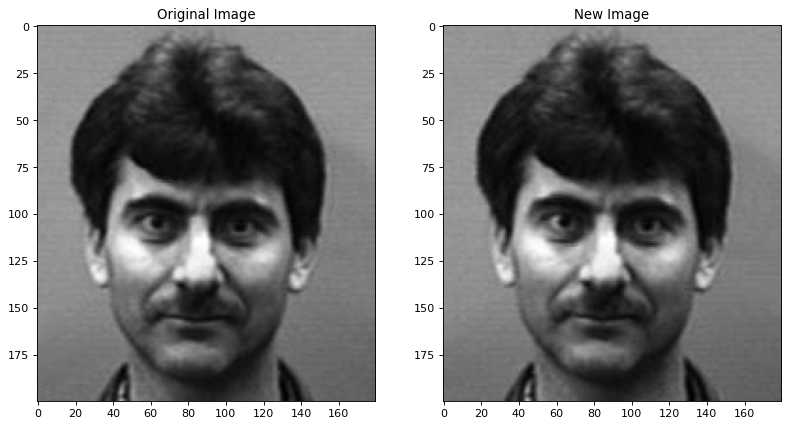

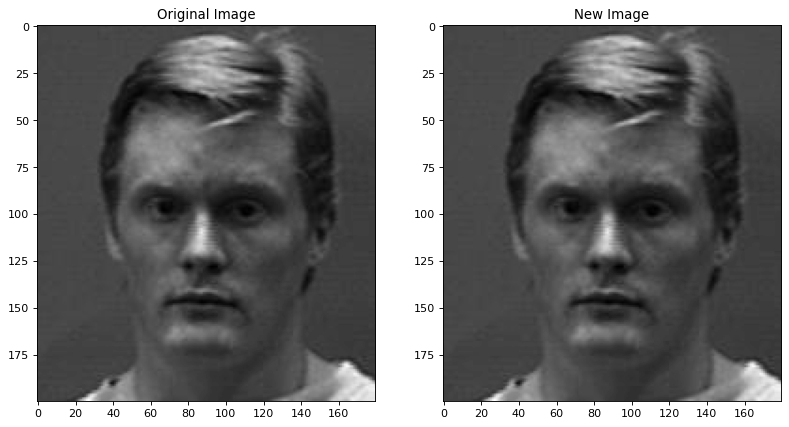

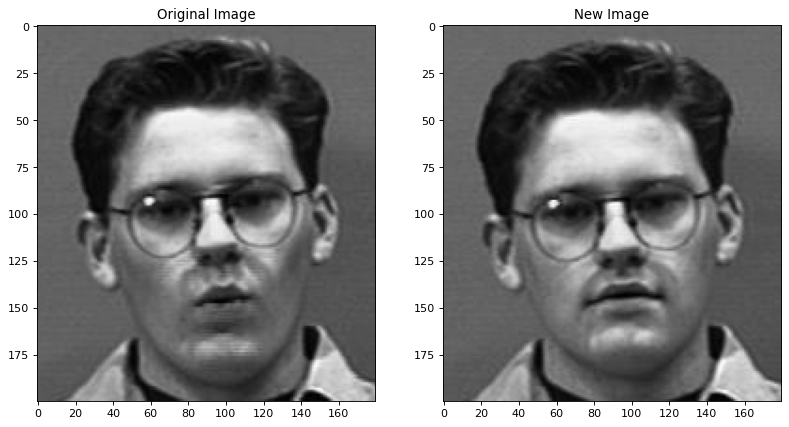

In [11]:
# display output for match function
for test_image in sample_faces(5):
    facial.match(test_image)